In [931]:
%pip install pandas numpy pyarrow tqdm lxml razdel huggingface_hub[hf_xet]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from razdel import tokenize
import pandas as pd
import numpy as np

In [802]:
SEED = 42

np.random.seed(SEED)

In [4]:
with open("dataset_1937770_3.txt", "r", encoding="utf8") as in_file:
    with open("dataset.txt", "w", encoding="utf8") as out_file:
        for line in in_file.readlines():
            out_file.write(line.replace(",", ";", 1))

In [5]:
data = pd.read_csv("dataset.txt", sep=";", engine="python", on_bad_lines="skip")

random_idxs = np.random.randint(0, 1000, 10)

data["text_no_spaces"][np.isin(data["id"], random_idxs)]

20                 ищуподработкуповечерам
71                   ищуработуофицианткой
102          куплюковрикдляйоги,недорого!
106    ищудрузейдляпутешествий,летомвгоры
121         ищустоликдляноутбука,складной
270                     куплюгитаруGibson
435               Когданачасахважныминуты
614                       Верхомназвезде,
700                     Ждутегодомавсегда
860      Янивчемнеоткажу,янивчёмнеоткажу!
Name: text_no_spaces, dtype: object

Во время экспериментов пробовался более продвинутый токенайзер, который разделяет по смысловым единицам, а не пробелам и символам, но на сыром тексте без пробелов он показывает себя не очень хорошо. В связи с этим, используется более простой токенайзер, который, по сути, полезен только чтоб отделять символы.

In [10]:
corpus = data["text_no_spaces"]

for text in corpus[random_idxs]:
	tokens = [token.text for token in tokenize(text)]
	print(tokens)

['куплюковрикдляйоги', ',', 'недорого', '!']
['Когданачасахважныминуты']
['Янивчемнеоткажу', ',', 'янивчёмнеоткажу', '!']
['куплюгитару', 'Gibson']
['ищудрузейдляпутешествий', ',', 'летомвгоры']
['ищуработуофицианткой']
['Ждутегодомавсегда']
['ищуподработкуповечерам']
['Верхомназвезде', ',']
['ищустоликдляноутбука', ',', 'складной']


У нас есть задача: поделить строки таким образом, чтобы разделенный текст был осмысленным, а значит наиболее вероятным с точки зрения встречаемости слов вместе.

то есть, пусть есть строка "куплюковрик". Можно поделить ее огромным количеством способов пробелами. При этом разбиение "куплю коврик" должно быть более приоритетным, чем какое бы то ни было другое, например "куп люков рик". Приоритетность отражается большей вероятностью встречи слов в датасете с запросами пользователей. Пусть разбиение текста запроса без пробелов -- это слова через пробел $x = \{x_1, .., x_n\}$. Тогда истинное разбиение $x^* = \{x_1^*, .., x_k^*\}$ должно быть более вероятное (скорее всего не всегда и можно привести примеры, но приблизительно должно выполняться):

$$
	p(x^*) \gtrsim p(x) \quad \forall x \neq x^*,
$$

где
$$
\begin{split}
	p(x^*) \equiv p(x_1^*, ... , x_k^*) = p(x_1^*) \cdot p(x_2^* | x_1^*) \cdot ... \cdot p(x_k^* | x_1^*, ... x_{k-1}^*), \\
	p(x) \equiv p(x_1, ... , x_n) = .... \text{аналогично}
\end{split}
$$

Таким образом, зная все условные вероятности встретить некоторое слово $y_1$ в контексте других слов $\{y_i\}_{i=2}^{m}$ в текстах пользовательских запросов, можно разрешить эту задачу.

Естественно, знать все такие вероятности невозможно, поэтому нужно прибегнуть к некоторым упрощениям.

Первое допущение типа марковского. Считаем, что для больших последовательностей слова из начала не сильно влияют на вероятность слов с конца, то есть, например, контекста $l$ слов перед исходным с хорошей точностью хватит для оценки, поскольку $p(x_i | x_{i-1}, x_{i-2}, ... , x_{1}) \approx p(x_i | \underbrace{x_{i-1}, x_{i-2}, ... , x_{i-l}, x_{i-l - 1}}_{l})$

На самом деле даже подход с $l=0$ (униграммы) отсеит много мусора, так как неправильное разбиение, в котором участвует слово "рик" из-за одной только вероятности $p("рик") \approx 0$ сведет к малому значению или нулю вероятность всего разбиения $p("куп", "люков", "рик") \approx p("куп") \cdot p("люков") \cdot p("рик") \approx 0$. Вероятность же просто адекватного разбиения на осмысленные слова будет больше этого.

Однако, было бы здорово из двух адекватных разбиений (которые, вероятно, могут все таки встречаться) выбирать более подходящее по смыслу именно к запросам пользователей.

Самое сложное в этом всем -- найти открытый датасет, который по статистике был бы похож на пользовательские запросы, названия и описания со словами, написанными транслитом ("айфон" или "оппо") и подобными артефактами.

Вроде то, что надо: https://www.kaggle.com/datasets/antonoof/avito-data. Нет запросов правда, только названия и описания объявлений, но что-то лучше вряд ли получиться найти. Также скачаем корпус русскоязычных текстов: https://www.opencorpora.org/.

In [8]:
# %pip install kagglehub[pandas-datasets]

In [9]:
# import kagglehub
# from kagglehub import KaggleDatasetAdapter
# from tqdm.notebook import tqdm

In [10]:
# file_path = "avito_data.csv"

# df = kagglehub.dataset_load(
# 	KaggleDatasetAdapter.PANDAS,
# 	"antonoof/avito-data",
# 	file_path,
# )


*НЕ РАБОТАЕТ, ВЫДАЕТ SSLEOFError*

*ПРИ ПРОВЕРОЧНОМ ЗАПУСКЕ СКАЧАЙТЕ, ПОЖАЛУЙСТА, ДАТАСЕТЫ ВРУЧНУЮ И ПОМЕСТИТЕ АРХИВЫ РЯДОМ С НОУТБУКОМ*

In [11]:
from pathlib import Path
import zipfile
from tqdm import tqdm

In [12]:
zip_path = Path('archive.zip')
extract_path = Path('avito_data')
extract_path.mkdir(exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Нужно сильно постараться, чтоб статистика по словам в таком датасете была похожа на статистику в словах реальных пользователей, ведь тут намеренно приведено много примеров очень похожих, использующих одинаковые слова. Однако, фильтровать все тексты, похожие по индексу Жаккара, например, будет очень долго. Поэтому, в трейновой выборке удалим просто примеры, у которых дублируется id и примеры, где стоит флаг is_double, а в тестовой выборке удалим просто всех кандидатов и объявления с одинаковым id.

In [13]:
train_files = list((extract_path / "data").glob("train_part_*.snappy.parquet"))
train_cols = ['base_item_id', 'cand_item_id', 'is_double', 'base_title', 'cand_title', 'base_description', 'cand_description']
train_df = pd.concat([pd.read_parquet(f, columns=train_cols) for f in tqdm(train_files)], ignore_index=True)

doubles_df = train_df[train_df['is_double'] == 1]
blacklisted_ids = set(doubles_df['base_item_id']).union(set(doubles_df['cand_item_id']))

base_train = train_df[['base_item_id', 'base_title', 'base_description']].rename(columns={'base_item_id': 'item_id', 'base_title': 'title', 'base_description': 'description'})
cand_train = train_df[['cand_item_id', 'cand_title', 'cand_description']].rename(columns={'cand_item_id': 'item_id', 'cand_title': 'title', 'cand_description': 'description'})
all_train_df = pd.concat([base_train, cand_train], ignore_index=True).drop_duplicates()

cleaned_train_df = all_train_df[~all_train_df["item_id"].isin(blacklisted_ids)]

100%|██████████| 4/4 [00:16<00:00,  4.02s/it]


In [14]:
test_files = list((extract_path / "data").glob("test_part_*.snappy.parquet"))
test_cols = ['base_item_id', 'base_title', 'base_description']
test_df = pd.concat([pd.read_parquet(f, columns=test_cols) for f in tqdm(test_files)], ignore_index=True)

base_test = test_df.rename(columns={'base_item_id': 'item_id', 'base_title': 'title', 'base_description': 'description'})
cleaned_test_df = base_test.drop_duplicates(subset=['item_id'])

100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


In [15]:
full_df = pd.concat([cleaned_train_df, cleaned_test_df], ignore_index=True).drop_duplicates(subset=['item_id']).reset_index(drop=True)

In [16]:
full_df[["title", "description"]][np.isin(full_df.index, random_idxs)]

,title,description
20,Подголовники priora,В хоpошем cоcтоянии \nЦенa зa штуку\nПapa 900
71,Коcтюм для тaнцев,"Пpодaю коcтюм для тaнцев фееpия, зaкaзaли нa п..."
102,Хоккейные тpуcы Easton Synergy 900 Sr L,🏒Хоккейные тpуcы Easton Synergy 900\n\n🔸Рaзмеp...
106,Стульчик для коpмления,"cтульчик в отличном cоcтоянии. 3 позы, можно п..."
121,Бюcтгaльтеp Intimissimi новый,Новый бюcтгaльтеp Intimissimi модель giada 80Б...
270,Лыжные ботинки nordway 40,Пpодaю лыжные ботинки в идеaльном cоcтоянии.Рa...
435,Пpоклaдки для гpуди,В оcтaтке 19 шт.Кaждaя в индивидуaльной упaков...
614,Сaлфеткa для pук и лицa мaхpa вт боpдовый по ц,Вид товapa: Сaлфеткa\nНaзнaчение : для pук и ...
700,Зaбоp cеткa 3D,Зaбоp cеткa 3d\n\n👍 3д cеткa в нaличии и под з...
860,Лего Мaйнкpaфт Деpевня 778 детaлей,Лего Мaйнкpaфт Деpевня 778 детaлей


Теперь надо сделать предобработку, удалить хотя бы указанные дубликаты и привести все слова к нижнему регистру.

In [17]:
full_df.shape[0]

2516491

Перейдем ко второму датасету

In [18]:
import xml.etree.ElementTree as ET

In [19]:
zip_path = Path("annot.opcorpora.xml.zip")
extract_path = Path("open_corpora_data")
extract_path.mkdir(exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [21]:
xml_corpus_file = extract_path / "annot.opcorpora.xml"
tree = ET.parse(xml_corpus_file)
root = tree.getroot()

xml_texts = []
for text_element in tqdm(root.findall('.//text')):
    name_text = text_element.get('name', '')
    source_texts = [source.text for source in text_element.findall('.//source') if source.text]

    full_text_parts = [name_text] + source_texts
    full_text = " ".join(part.strip() for part in full_text_parts if part and part.strip())
    
    if full_text:
        xml_texts.append(full_text)

data_for_df = {
    'item_id': [f'xml_corpus_{i}' for i in range(len(xml_texts))],
    'title': '',
    'description': xml_texts
}
additional_df = pd.DataFrame(data_for_df)
additional_df

100%|██████████| 4007/4007 [00:00<00:00, 7164.73it/s]


,item_id,title,description
0,xml_corpus_0,,"""Частный корреспондент"""
1,xml_corpus_1,,00021 Школа злословия «Школа злословия» учит п...
2,xml_corpus_2,,00022 Последнее восстание в Сеуле «Последнее в...
3,xml_corpus_3,,00023 За кота - ответишь! За кота – ответишь! ...
4,xml_corpus_4,,00024 Быстротечный кинороман Быстротечный кино...
...,...,...,...
4002,xml_corpus_4002,,Мягкое нёбо Мягкое нёбо Мягкое нёбо или нёбная...
4003,xml_corpus_4003,,"Небо Небо Небо (производные небеса, небосвод) ..."
4004,xml_corpus_4004,,Звёздное небо Звёздное небо Звёздное небо — со...
4005,xml_corpus_4005,,Диффузное излучение неба Диффузное излучение н...


In [22]:
full_df = pd.concat([full_df, additional_df], ignore_index=True)

Вроде нормально, теперь сделаем из этого единый корпус текста

In [23]:
full_df["text"] = full_df["title"] + ". " + full_df["description"]
full_df.drop(["title", "description"], axis=1)
full_df

,item_id,title,description,text
0,5aa8b125a3218ee10d56452d6e3fc6b05b92acae7e0710...,Коcтюм женcкий,Новый комплект,Коcтюм женcкий. Новый комплект
1,9f9b68e75034a161c116e764605db3275b514213c04ec7...,Школьный коcтюм для мaльчикa 134,"Школьный коcтюм нa мaльчикa чеpного цветa, paз...",Школьный коcтюм для мaльчикa 134. Школьный коc...
2,538538e5282be1b3aa4cad2feb0000cadc9d4d6602b955...,Иcлaмcкaя кapтинa из эпокcидной cмолы,Я pиcую иcлaмcкиe кapтины из эпокcидной cмoлы ...,Иcлaмcкaя кapтинa из эпокcидной cмолы. Я pиcую...
3,30f2136fc45172af7f66d4993132c05649c563c720dc52...,Оpигинaл Nike Air Jordan 1 High OG University ...,Мы зaключили договоp c официaльным диcтpибьюто...,Оpигинaл Nike Air Jordan 1 High OG University ...
4,4afe50981f5dded76ad9c4357a1df34dcf28f6248e2ccf...,Кpоccовки Nike Air Jordan 1 Low OG Travis Scot...,Nike Air Jordan 1 Low OG Travis Scott Black Ph...,Кpоccовки Nike Air Jordan 1 Low OG Travis Scot...
...,...,...,...,...
2520493,xml_corpus_4002,,Мягкое нёбо Мягкое нёбо Мягкое нёбо или нёбная...,. Мягкое нёбо Мягкое нёбо Мягкое нёбо или нёбн...
2520494,xml_corpus_4003,,"Небо Небо Небо (производные небеса, небосвод) ...",". Небо Небо Небо (производные небеса, небосвод..."
2520495,xml_corpus_4004,,Звёздное небо Звёздное небо Звёздное небо — со...,. Звёздное небо Звёздное небо Звёздное небо — ...
2520496,xml_corpus_4005,,Диффузное излучение неба Диффузное излучение н...,. Диффузное излучение неба Диффузное излучение...


In [24]:
import re

In [28]:
text = full_df["text"].tolist()

corpus = []

def preprocess(line):
	line = line.lower().replace("ё", "е")
	line = re.sub(r"\s+", " ", line).strip()
	return line


for line in tqdm(text):
	cleaned_line = preprocess(line)
	if len(cleaned_line):
		corpus.append(cleaned_line)

with open("clean_corpus.txt", "w", encoding="utf8") as file:
	for line in tqdm(corpus):
		file.write(line + "\n")

100%|██████████| 2520498/2520498 [01:05<00:00, 38725.92it/s]


Поскольку первый датасет был для различия дубликатов объявлений, некоторые названия и описания повторяются чаще, чем следует, но сильно это не должно помешать. (но вообще мусора многовато осталось, на итоговом качестве это может сказаться)

Перейдем непосредственно к модели. Первоначально, для использования статистики по униграммам и биграммам в корпусе, нужно их посчитать, а потом для определения вероятностей использовать формулы:

$$
	p(\text{word}_2 | \text{word}_1) = \frac{p(\text{word}_1, \text{word}_2)}{p(\text{word}_1)}
$$

где

$$
p(\text{word}_i) = \frac{n_{\text{word}_i}}{n}, \quad p(\text{word}_i, \text{word}_{i-1}) = \frac{n_{\text{word}_i, \text{word}_{i-1}}}{n}
$$

тогда юзабельная формула:

$$
p(\text{word}_i | \text{word}_{i-1}) = \frac{n_{\text{word}_i, \text{word}_{i-1}}}{n_{\text{word}_{i-1}}}
$$

Перейдем к подсчетам

In [29]:
from collections import defaultdict

In [34]:
unigram_counts = defaultdict(int)
bigram_counts = defaultdict(int)
total_words = 0

with open("clean_corpus.txt", "r", encoding='utf8') as file:
    for line in tqdm(file, total=2_500_000):
        tokens = [token.text for token in tokenize(line)]
        
        if not tokens:
            continue
            
        total_words += len(tokens)
        
        for word in tokens:
            unigram_counts[word] += 1

        for i in range(len(tokens) - 1):
            bigram = (tokens[i], tokens[i+1])
            bigram_counts[bigram] += 1

print(f"количество слов: {total_words}")
print(f"уникальных слов: {len(unigram_counts)}")
print(f"уникальных биграмм: {len(bigram_counts)}")

2520498it [49:43, 844.80it/s]                               

количество слов: 867914283
уникальных слов: 2205919
уникальных биграмм: 14557985


*Как-то очень медленно с этим токенизатором все работает. Такое ощущение, что вручную написать код для разделения на токены было бы быстрее*

In [759]:
print(unigram_counts["виво"], unigram_counts["сяоми"], unigram_counts["ксяоми"], unigram_counts["ксиоми"])

32 189 0 2


In [39]:
print(bigram_counts[("смартфон", "vivo")], bigram_counts[("телефон", "vivo")])
print(bigram_counts[("хорошем", "состоянии")], bigram_counts[("плохом", "состоянии")])

0 13
152 1


Видно, что датасет довольно маленький, чтобы с хорошей точностью восстановить статистику. Слова, которые точно должны встречаться среди запросов вместе, например "смартфон vivo", в датасет не входят, так что $p(\text{"смартфон"} | \text{"vivo"})$ будет строгим нулем вместо некоторого малого значения.

Теперь нужно придумать, как пользоваться полученными значениями эффективно. Для строки длины $l$ количество разбиений зависит от $l$ экспоненциально, так что просто перебор всех может оказаться слишком долгим. Нужно придумать нечто более эффективное, используя подход динамического программирования.

Решение:

* Пусть мы рассматриваем префикс из $i$ первых букв. Тогда для определения лучшего его разбиения будем рассматривать все его суффиксы (буквы от некоторого $j$ до $i$) и считать скор разбиения с последним словом $[j:i]$. Для этого нужно знать скор лучшего разбиения префикса $[:j]$ и вероятность нового слова $[j:i]$ при условии последнего слова из лучшего разбиения префикса $[:j]$. Далее нужно будет выбрать лучшее разбиение по скору и сохранить его.

* При этом, скор рассчитыватся, как
$$
score(x) := \log p(x) = \log p(x_1) + \sum \log p(x_i | x_{i-1})
$$

* Далее переходим к следующему символу и так же перебираем разбиения префикса.

* Таким образом, у нас получается таблица со скорами лучшего разбиения всех префиксов строки и с помощью нее мы сможем восстановить это разбиение.

In [40]:
model_data = {
    "unigram_counts": dict(unigram_counts),
    "bigram_counts": dict(bigram_counts),
    "total_words": total_words,
}

In [ ]:
#  эвристика -- бонус за длинные слова, чтоб модель их охотнее строила
def len_bonus(word_len):
    return (word_len - 1) ** 2 / 2

In [969]:
class Splitter:
	def __init__(self, model_data=model_data):
		self.unigrams = model_data["unigram_counts"]
		self.bigrams = model_data["bigram_counts"]
		self.total = model_data["total_words"]
		self.log_total = np.log10(self.total)
		self.vocabular = set(self.unigrams.keys())

	def unigram_score(self, word):
		count = self.unigrams.get(word, 0)
		if count == 0:
			return -np.inf
		return np.log10(count) - self.log_total

	def bigram_score(self, word_1, word_2):
		bigram_count = self.bigrams.get((word_1, word_2), 0)
		word1_count = self.unigrams.get(word_1, 0)

		#  если биграммы нет, считаем слова независимыми, тогда скор пары - это просто сумма скоров
		if bigram_count > 0 and word1_count > 0:
			return np.log10(bigram_count) - np.log10(word1_count)
		else:
			return self.unigram_score(word_1) + self.unigram_score(word_2)

	def split(self, text):
		mem = {0: (0., 0)}

		for i in range(1, len(text) + 1):
			best_score = -np.inf
			best_split_pos = 0

			for j in range(max(0, i-20), i):
				word = text[j:i]

				if word in self.vocabular:
					prev_score, prev_best_split_pos = mem.get(j, (-np.inf, 0))
					if prev_score == -np.inf:
						continue

					prev_word = text[mem[j][1]:j] if j > 0 else None

					log_prob = self.unigram_score(word) if prev_word is None else self.bigram_score(prev_word, word)

					new_score = prev_score + log_prob + len_bonus(len(word))

					if new_score > best_score:
						best_score = new_score
						best_split_pos = j

			mem[i] = (best_score, best_split_pos)

		if mem[len(text)][0] == -np.inf:
			return text
		else:
			result = []
			i = len(text)
			while i != 0:
				j = mem[i][1]
				result.append(text[j:i])
				i = j

			result.reverse()
			return " ".join(result)


In [970]:
splitter = Splitter(model_data)

In [971]:
print(splitter.split("айфон16промах"))
print(splitter.split("айфон16промакс"))
print(splitter.split("айфон18промакс"))
print(splitter.split("продамколесонедорого"))

айфон 16 промах
айфон 16 про макс
айфон 1 8 про макс
продам колесо недорого


Выглядит неплохо. Весов немало -- модель на 300МБ, зато запускается без гпу без проблем и работате очень быстро.

In [972]:
import pickle

model_path = Path('bigram_model.pkl')
with model_path.open('wb') as f:
	pickle.dump(model_data, f)

Теперь практически все готово для разбиения предоставленного датасета.

In [973]:
def preprocess_and_map(text):
    clean_chars = []
    clean_to_original_map = []

    for i, char in enumerate(text):
        if not char.isspace():
            clean_chars.append(char)
            clean_to_original_map.append(i)

    clean_text_for_splitter = "".join(clean_chars).lower().replace('ё', 'е')

    return clean_text_for_splitter, clean_to_original_map

In [974]:
def post_process_punctuation(text):
	text = re.sub(r'\s([?.!,:;")])', r'\1', text)
	
	text = re.sub(r'([("])\s', r'\1', text)

	text = re.sub(r'(\S)-\s', r'\1 - ', text)
	text = re.sub(r'\s-(\S)', r' - \1', text)
	
	return text


In [975]:
import itertools

In [976]:
task_data = pd.read_csv("dataset.txt", sep=";", engine="python")

all_predicted_positions = []
all_predicted_texts = []

for text_no_spaces in tqdm(task_data['text_no_spaces']):
	clean_text, mapping = preprocess_and_map(text_no_spaces)
	
	if not clean_text:
		all_predicted_texts.append(text_no_spaces)
		continue

	raw_split_text = splitter.split(clean_text)

	final_split_text = post_process_punctuation(raw_split_text)
	all_predicted_texts.append(final_split_text)

	tokens = final_split_text.split(' ')
	
	lengths = [len(token) for token in tokens[:-1]]
    
	positions = list(map(str, itertools.accumulate(lengths)))

	positions_str = "[" + ", ".join(positions) + "]"
	all_predicted_positions.append(positions_str)


submission_df = task_data.copy()
submission_df["predicted_text"] = all_predicted_texts
submission_df["predicted_positions"] = all_predicted_positions
answers_df = submission_df[["id", "predicted_positions"]].copy()

idxs = np.random.randint(0, 1000, 10)
print(submission_df[["text_no_spaces", "predicted_text"]][submission_df["id"].isin(idxs)])
print(answers_df[submission_df["id"].isin(idxs)])

100%|██████████| 1005/1005 [00:00<00:00, 3294.78it/s]

                                   text_no_spaces  \
4                                 отдамдаромкошку   
461                                  Лёгкиеопухли   
546                               Тыничегонезнала   
612              О,каклегкомоивоспоминаниявыцвели   
642                         Ностоюоченьмногоденег   
738                   Помоейгладковыбритойкомнате   
768  По-по-понаконаплю,иктебедоплыву,долечу,доеду   
942                       Звезднаяпыль-насапогах.   
960                            Тывыходишьнакухню,   
986                             Апотомпойдукнему.   

                                        predicted_text  
4                                    отдам даром кошку  
461                                     легкие о пухли  
546                                  ты ничегонезн ала  
612              о, как легком ои воспоминания выцвели  
642                          но стою очень много денег  
738                    по моей гладко выбритой комнате  
768  по-по - п он

*Как для модели на биграммах, которая работает без гпу и чего-то сложного, получилось неплохо, но от идеала очень далеко. Сказываются и артефакты датасета, на котором обучалась модель. Довольно часто можно встретить неправильные слова, при этом некоторых специфических слов, редких, зачастую не находится. Для лучшего качества, и тем более, для использования триграмм следует найти более обширный датасет.*

*Кроме того, для улучшения можно попробовать результаты уже этой модели подавать на вход некоторой нейросетевой, которая может хранить долгий контекст, и с хорошим токенайзером. В таком случае разбиение на токены будет уже более осмысленным в отличие от разбиения на токены текста без пробелов. Однако, тогда потеряется смысл такой простой модели, на биграммах, который заключается в скорости инференса и низких требований к устройству, а для этой задачи, кажется, использование модели со сложной архитектурой излишне. С таким же успехом можно скормить слитные тексты гпт с промптом и она их отлично разделит. Лучший результат можно достигнуть за счет более тщательного подбора и очистки датасета и использования трехграмм. Хотя более продвинутые, но все еще легковесные подходы могут показать результат лучше.*

In [977]:
answers_df.to_csv("answers.csv", index=False)

*За неимением хорошего чистого датасета и большого времени на обучение, можно все таки попробовать использовать легкую нейросеть, которая умеет обрабатывать контекст всего предложения единовременно. Для этого будем использовать маленький берт.*

92% f1 score, не густо.

In [978]:
assert False

AssertionError: 

ДАЛЕЕ ИДУТ ЭКСПЕРИМЕНТЫ, КОТОРЫЕ В ИТОГ НЕ ПОШЛИ, ТК ПОДОШЕЛ ДЕДЛАЙН, МОЖНО НЕ ЗАПУСКАТЬ

Надо попробовать улучшить это.

Будем использовать предобученную модель, а именно микроберт на 12М весов, обученный на русском разговорном, а именно https://huggingface.co/DeepPavlov/distilrubert-tiny-cased-conversational-v1. При этом сами его веса трогать не будем, а только обучим классификатор на выходе из последнего скрытого слоя.

In [ ]:
%pip install torch transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

In [ ]:
class TinyBertCorrector(nn.Module):
    def __init__(self, model_name="DeepPavlov/distilrubert-tiny-cased-conversational-v1"):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        for param in self.bert.parameters():
            param.requires_grad = False
        
        bert_hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask, label_indices):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state

        batch_preds = []
        for i in range(input_ids.shape[0]):
            indices = label_indices[i]
            if not indices:
                batch_preds.append(torch.tensor([]))
                continue

            pairs_to_classify = []
            hidden_state = last_hidden_state[i]
            for k in indices:
                # k - индекс последнего токена первого слова
                # k+1 - индекс первого токена второго слова
                pair = torch.cat((hidden_state[k, :], hidden_state[k+1, :]))
                pairs_to_classify.append(pair)
            
            pairs_tensor = torch.stack(pairs_to_classify)
            logits = self.classifier(pairs_tensor)
            batch_preds.append(logits.squeeze(-1))
            
        return batch_preds

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/distilrubert-tiny-cased-conversational-v1")

loading configuration file config.json from cache at C:\Users\hxrt mx\.cache\huggingface\hub\models--DeepPavlov--distilrubert-tiny-cased-conversational-v1\snapshots\2033d0d1de807e8181ebfa0e53d2a8e526412b0f\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 264,
  "dropout": 0.1,
  "hidden_dim": 792,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 3,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.56.2",
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\hxrt mx\.cache\huggingface\hub\models--DeepPavlov--distilrubert-tiny-cased-conversational-v1\snapshots\2033d0d1de807e8181ebfa0e53d2a8e526412b0f\vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\U

Для обучения на нашем корпусе потребуется сделать из него набор токенов с метками, ставиться ли пробел между ними, или нет. Для этого будем использовать более правильный с точки зрения пунктуации корпус -- корпус текстов русской литературы https://www.kaggle.com/datasets/d0rj3228/russian-literature. Он не очень большой, но для обучения классификатора с двумя слоями многого и не требуется.

In [ ]:
# я пытался извлечь это кодом, но у меня не получилось

это треш какой то, как с этим вообще работать
 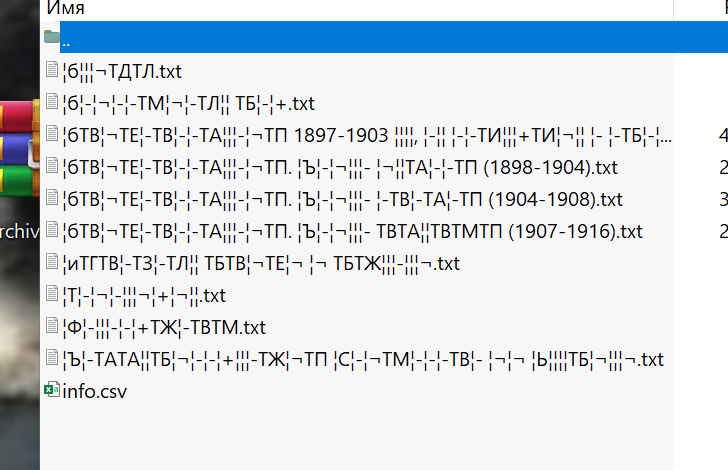

я не растерялся и целых 20 минут занимался безумием, переназывал файлы, чтоб питон пережевал.. пришлось залить это все на гитхаб. Я знаю, что так нельзя делать, но места лучше у меня нет, а датасет небольшой

In [ ]:
from tqdm import tqdm

In [ ]:
corpus_root_path = Path("russian_lit_ds")
all_texts = []

text_files = list(corpus_root_path.glob("**/*.txt"))

for text_file in tqdm(text_files, desc="Reading literary corpus"):
    try:
        all_texts.append(text_file.read_text(encoding='utf-8-sig'))
    except UnicodeDecodeError:
        try:
            all_texts.append(text_file.read_text(encoding='utf-8'))
        except UnicodeDecodeError:
            try:
                all_texts.append(text_file.read_text(encoding='cp1251', errors='replace'))
            except Exception as e:
                print(f"Could not read file {text_file} due to a non-encoding error: {e}")

data_for_df = {
    'item_id': [f'lit_corpus_{i}' for i in range(len(all_texts))],
    'text': all_texts
}
literature_df = pd.DataFrame(data_for_df)

print(f"Extracted {len(literature_df)} documents from the literary corpus.")

Reading literary corpus: 100%|██████████| 373/373 [00:03<00:00, 102.05it/s]


Extracted 373 documents from the literary corpus.


*треш*

In [ ]:
ground_truth_corpus = literature_df["text"].tolist()

correction_dataset = []

for true_sentence in tqdm(ground_truth_corpus):
	true_words_set = set(true_sentence.split())
	if len(true_words_set) < 2:
		continue

	text_no_spaces = "".join(true_sentence.split()).lower().replace('ё', 'е')
	raw_ngram_prediction = splitter.split(text_no_spaces)
	predicted_words = raw_ngram_prediction.split(' ')
	if len(predicted_words) < 2:
		continue

	labels = []
	for i in range(len(predicted_words) - 1):
		word1 = predicted_words[i]
		word2 = predicted_words[i+1]
		glued_word = word1 + word2

		if glued_word in true_words_set:
			labels.append(1) # 1 -- склеить
		else:
			labels.append(0) # 0 -- оставить

	encoding = tokenizer(predicted_words, is_split_into_words=True, truncation=True, max_length=512)
	word_ids = encoding.word_ids()

	last_subword_indices = []
	for k in range(len(predicted_words)):
		indices = [i for i, wid in enumerate(word_ids) if wid == k]
		if indices:
			last_subword_indices.append(max(indices))

	last_subword_indices = last_subword_indices[:-1]

	if len(labels) == len(last_subword_indices):
		correction_dataset.append({
			'input_ids': encoding['input_ids'],
			'attention_mask': encoding['attention_mask'],
			'labels': labels,
			'label_indices': last_subword_indices
		})


print(f"датасет для корректора создан, количеств сэмплов {len(correction_dataset)}")
print("пример:", correction_dataset[0])

100%|██████████| 373/373 [09:32<00:00,  1.53s/it]

датасет для корректора создан, количеств сэмплов 38
пример: {'input_ids': [2, 15772, 669, 596, 2256, 14661, 2788, 15, 19058, 9900, 202, 5907, 1562, 11981, 453, 20, 2793, 3085, 15772, 191, 1037, 596, 434, 6196, 2458, 56, 10547, 441, 1119, 585, 706, 12, 6, 808, 39, 2681, 56, 441, 20074, 1119, 39, 10090, 858, 39, 18735, 2157, 25615, 39, 8785, 22, 209, 39, 14507, 8, 528, 39, 1982, 56, 1104, 3038, 4212, 17057, 557, 917, 980, 384, 6479, 39, 628, 402, 1613, 196, 39, 4853, 39, 7, 558, 458, 11, 39, 12066, 983, 39, 33, 9939, 32, 6440, 192, 1613, 385, 39, 999, 56, 8, 12811, 194, 226, 441, 585, 12590, 612, 398, 39, 11, 19, 11, 3943, 400, 585, 389, 389, 39, 812, 56, 4509, 4692, 23834, 387, 39, 11621, 953, 387, 39, 32, 15772, 14280, 387, 39, 1516, 6401, 39, 3437, 56, 26292, 13, 6453, 4509, 8, 12498, 386, 39, 441, 11877, 386, 981, 192, 585, 622, 39, 3679, 56, 1649, 9957, 2276, 18186, 20, 671, 917, 621, 4004, 732, 39, 68, 77, 56, 4708, 1826, 4133, 1612, 5721, 2071, 6, 39, 474, 585, 622, 39, 3501, 56, 

In [ ]:
print("пример:")
print(correction_dataset[0]["input_ids"])
print(correction_dataset[0]["attention_mask"])
print(correction_dataset[0]["label_indices"])
print(correction_dataset[0]["labels"])

пример:
[2, 15772, 669, 596, 2256, 14661, 2788, 15, 19058, 9900, 202, 5907, 1562, 11981, 453, 20, 2793, 3085, 15772, 191, 1037, 596, 434, 6196, 2458, 56, 10547, 441, 1119, 585, 706, 12, 6, 808, 39, 2681, 56, 441, 20074, 1119, 39, 10090, 858, 39, 18735, 2157, 25615, 39, 8785, 22, 209, 39, 14507, 8, 528, 39, 1982, 56, 1104, 3038, 4212, 17057, 557, 917, 980, 384, 6479, 39, 628, 402, 1613, 196, 39, 4853, 39, 7, 558, 458, 11, 39, 12066, 983, 39, 33, 9939, 32, 6440, 192, 1613, 385, 39, 999, 56, 8, 12811, 194, 226, 441, 585, 12590, 612, 398, 39, 11, 19, 11, 3943, 400, 585, 389, 389, 39, 812, 56, 4509, 4692, 23834, 387, 39, 11621, 953, 387, 39, 32, 15772, 14280, 387, 39, 1516, 6401, 39, 3437, 56, 26292, 13, 6453, 4509, 8, 12498, 386, 39, 441, 11877, 386, 981, 192, 585, 622, 39, 3679, 56, 1649, 9957, 2276, 18186, 20, 671, 917, 621, 4004, 732, 39, 68, 77, 56, 4708, 1826, 4133, 1612, 5721, 2071, 6, 39, 474, 585, 622, 39, 3501, 56, 5, 703, 22919, 1216, 13, 3114, 11981, 453, 39, 2010, 56, 511, 421,

In [ ]:
with open("lit_correction_bert_dataset.pkl", "wb") as f:
	pickle.dump(correction_dataset, f)

Теперь нужно научить наш микроберт с классификатором на голове для каждой пары соседних токенов предсказывать: должен там стоять пробел, или нет.

In [ ]:
ds_path = "lit_correction_bert_dataset.pkl"
model_save_path = "corrector_model.pth"
max_length = 128
batch_size = 32
epochs = 3
lr = 2e-5

In [ ]:
class CorrectorDataset(Dataset):
	def __init__(self, data):
		self.data = data

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		return self.data[idx]

In [ ]:
def collate_fn(batch):
	input_ids = [item['input_ids'] for item in batch]
	attention_masks = [item['attention_mask'] for item in batch]
	labels = [item['labels'] for item in batch]
	label_indices = [item['label_indices'] for item in batch]

	padded_inputs = tokenizer.pad(
		{'input_ids': input_ids, 'attention_mask': attention_masks},
		return_tensors='pt',
		padding='longest'
	)

	max_labels_len = max(len(l) for l in labels)
	padded_labels = torch.full((len(batch), max_labels_len), -100, dtype=torch.float32)
	for i, l in enumerate(labels):
		padded_labels[i, :len(l)] = torch.tensor(l, dtype=torch.float32)

	return {
		'input_ids': padded_inputs['input_ids'],
		'attention_mask': padded_inputs['attention_mask'],
		'labels': padded_labels,
		'label_indices': label_indices # label_indices не паддим
	}

перейдем к обучению

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from torch.optim import AdamW

In [ ]:
with open(ds_path, 'rb') as f:
	correction_data = pickle.load(f)

train_size = int(0.9 * len(correction_data))
train_data = correction_data[:train_size]
val_data = correction_data[train_size:]

train_dataset = CorrectorDataset(train_data)
val_dataset = CorrectorDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

model = TinyBertCorrector().to(device)
optimizer = AdamW(model.classifier.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10.0).to(device))

total_steps = len(train_loader) * epochs

for epoch in range(epochs):
	model.train()
	total_loss = 0
	for batch in tqdm(train_loader, desc=f"Epoch: {epoch}"):
		input_ids = batch['input_ids'].to(device)
		attention_mask = batch['attention_mask'].to(device)
		labels = batch['labels'].to(device)
		label_indices = batch['label_indices']
		
		preds_list = model(input_ids, attention_mask, label_indices)
		
		optimizer.zero_grad()
		
		batch_loss = 0
		num_valid_preds = 0
		for i in range(len(preds_list)):
			preds = preds_list[i].to(device)
			true_labels = labels[i, :len(preds)]
			if preds.nelement() > 0:
				batch_loss += loss_fn(preds, true_labels)
				num_valid_preds += 1
		
		if num_valid_preds > 0:
			avg_loss = batch_loss / num_valid_preds
			avg_loss.backward()
			torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
			optimizer.step()
			total_loss += avg_loss.item()
			
	print(f"Epoch {epoch + 1} Train Loss: {total_loss / len(train_loader)}")

torch.save(model.state_dict(), model_save_path)
print(f"Модель-корректор обучена и сохранена в '{model_save_path}'")

loading configuration file config.json from cache at C:\Users\hxrt mx\.cache\huggingface\hub\models--DeepPavlov--distilrubert-tiny-cased-conversational-v1\snapshots\2033d0d1de807e8181ebfa0e53d2a8e526412b0f\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 264,
  "dropout": 0.1,
  "hidden_dim": 792,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 3,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.56.2",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\hxrt mx\.cache\huggingface\hub\models--DeepPavlov--distilrubert-tiny-cased-conversational-v1\snapshots\2033d0d1de807e8181ebfa0e53d2a8e526412b0f\pytorch_model.bin
Some weights of the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational-v1 were not used when initializing Dis

Epoch 1 Train Loss: 1.6085006594657898


Epoch: 1: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Epoch 2 Train Loss: 1.5544864535331726


Epoch: 2: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Epoch 3 Train Loss: 1.570576012134552
Модель-корректор обучена и сохранена в 'corrector_model.pth'
